In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [50]:
def genObservations(pi, num_of_samples, means, covariances, seed=0):
    num_of_samples_class = [int(i*num_of_samples) for i in pi]
    num_of_classes = len(means)
    np.random.seed(seed)
    generated_samples = []
    for i in range(num_of_classes):
        samples = np.random.multivariate_normal(means[i], covariances[i], num_of_samples_class[i])
        generated_samples.extend(list(samples))
    return np.array(generated_samples)

def plotScatter(data):
    plt.figure(figsize=(10,10))
    plt.scatter(data[:,0], data[:,1])
    plt.xlabel("X-axis", fontsize=20)
    plt.ylabel("Y-axis", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(False)

####################
#K-MEANS CLUSTERING#
####################

class KMeans():

    def __init__(self, K, seed=0):
        self.K = K
        self.C = None
        self.seed = seed
        np.random.seed(seed)

    def setData(self, data):
        self.data = data
        (self.n, self.d) = data.shape
        self.C = np.empty(self.n)
        self.centroids = data[np.random.choice(self.n, size=self.K, replace=False), :]

    def calcLoss(self):
        Loss = 0
        for n in range(self.n):
            Loss += (np.linalg.norm(self.data[n, :] - self.centroids[int(self.C[n]), :]) ** 2)
        return Loss

    def updateClusters(self):
        for p in range(self.n):  # for every point
            D = np.Inf
            for k in range(self.K):  # check every cluster
                d = (np.linalg.norm(self.data[p, :] - self.centroids[k, :]) ** 2)
                if d < D:
                    self.C[p] = k
                    D = d

    def updateCentroids(self):
        for k in range(self.K):
            self.centroids[k] = np.mean(self.data[self.C == k, :], axis=0)

    def cluster(self, converge_condition=None):
        K = self.K
        data = self.data
        self.Loss = []
        if converge_condition != None:
            for i in range(converge_condition):
                self.updateClusters()
                self.updateCentroids()
                self.Loss.append(self.calcLoss())

        else:
            loss = 0
            while ((loss - self.calcLoss()) > 1):
                loss = self.calcLoss()
                self.updateClusters()
                self.updateCentroids()
                self.Loss.append(loss)

        self.setClusters()

    def setClusters(self):
        self.clusters = []
        for k in range(self.K):
            self.clusters.append(self.data[self.C == k, :])

    def plotLoss(self, save):
        sns.set_style('whitegrid')
        sns.set_context('poster')
        plt.figure(figsize=(30, 10))
        plt.plot(range(1, 21), self.Loss)
        plt.xlabel("Iterations", fontsize=20)
        plt.ylabel("Loss", fontsize=20)
        plt.title('Loss plot for K = {}'.format(self.K), fontsize=20)
        plt.xticks(range(1, 21), fontsize=20)
        plt.yticks(fontsize=20)
        if save:
            plt.savefig("1a_{}.png".format(self.K))
        else:
            plt.show()

    def plotScatter(self, save):
        sns.set_style('whitegrid')
        plt.figure(figsize=(10, 10))
        for k in range(self.K):
            plt.scatter(self.clusters[k][:, 0], self.clusters[k][:, 1], label="Cluster# {}".format(k + 1))
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], color="black", marker="*", s=288)
        plt.xlabel("X-axis", fontsize=20)
        plt.ylabel("Y-axis", fontsize=20)
        plt.title('Scatter plot for K = {}'.format(self.K), fontsize=20)
        plt.grid(False)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.legend(fontsize=20)
        if save:
            plt.savefig("1b_{}.png".format(self.K))
        else:
            plt.show()

######################        
#MATRIX FACTORIZATION#
######################

class MatrixFactorization():
    
    def __init__(self, d, l):
        self.d = d
        self.l = l
        
    def _genNormalVectors(self, N, d):
        m = np.empty((N,d))
        for i in range(N):
            m[i, :] = np.random.multivariate_normal(np.zeros(d), (1/self.l)*np.identity(d))
        return m
    
    def _initFactors(self):
        self.U = self._genNormalVectors(self.N1, self.d)
        self.V = self._genNormalVectors(self.N2, self.d)
    
    def importRatings(self, ratings):
        N2 = int(np.max(ratings[:, 1]))
        N1 =  int(np.max(ratings[:, 0]))
        rM = np.zeros((N1, N2))
        for i in range(len(ratings)):
            user_id, movie_id, rating = int(ratings[i, 0]), int(ratings[i, 1]), ratings[i, 2]
            rM[user_id - 1, movie_id - 1] = rating
        self.importM(rM)
        
    def importM(self, rM):
        self.M = rM
        (self.N1, self.N2) = rM.shape
        self._initFactors()
        self.M_mask = np.where(self.M != 0, 1, 0)
        
    def _updateU(self):
        for i in range(self.N1):
            supp = (self.M_mask[i, :] == 1)
            V = self.V[supp, :].T
            self.U[i, :] = np.linalg.inv((self.l*self.sigma*np.identity(self.d)) + V.dot(V.T)).dot(V.dot(self.M[i, supp].reshape(-1)))
            
    def _updateV(self):
        for j in range(self.N2):
            supp = (self.M_mask[:, j] == 1)
            U = self.U[supp, :].T
            self.V[j, :] = np.linalg.inv((self.l*self.sigma*np.identity(self.d)) + U.dot(U.T)).dot(U.dot(self.M[supp, j].reshape(-1)))
            
    def _calcJLL(self):
        A = (1/(2*self.sigma))*(np.linalg.norm(self.M - np.multiply(self.M_mask, self.U.dot(self.V.T)))**2)
        B = (self.l/2)*np.linalg.norm(self.U)
        C = (self.l/2)*np.linalg.norm(self.V)
        return (-1)*(A+B+C)
        
    def train(self, num_of_iterations, sigma):
        self.sigma = sigma
        self.JLLs = np.empty(num_of_iterations)
        for n in range(num_of_iterations):
            self._updateU()
            self._updateV()
            self.JLLs[n] = self._calcJLL()
            
    def _calcRMSE(self, truth, predictions):
        return ((np.linalg.norm(truth - predictions)**2)/truth.shape[0])** 0.5
    
    def testPredict(self, ratings_test):
        predictions = np.empty(ratings_test.shape[0])
        for i in range(predictions.shape[0]):
            user_id, movie_id = int(ratings_test[i, 0]), int(ratings_test[i, 1])
            predictions[i] = self.predict(user_id, movie_id)
        ground_truth = ratings_test[:, 2]
        return predictions, self._calcRMSE(ground_truth, predictions)
    
    def predict(self, user_id, movie_id):
        return self.U[user_id - 1, :].dot(self.V[movie_id - 1, :].T)
        
    def recommendMovies(self, movie_id, k):
        v = self.V[movie_id - 1, :]
        V = self.V - v
        d = np.linalg.norm(V, axis=1)
        order = np.argsort(d)
        top_k_movies = np.array(range(1, self.N2 + 1))[order][1:k+1]
        top_k_distances = d[order][1:k+1]
        return top_k_movies, top_k_distances

################    
#TEST FUNCTIONS#
################

def testPart1():
    m1 = np.array([0, 0])
    cov1 = np.identity(2)
    m2 = np.array([3, 0])
    cov2 = np.identity(2)
    m3 = np.array([0, 3])
    cov3 = np.identity(2)
    data = genObservations([0.2, 0.5, 0.3], 500, [m1, m2, m3], [cov1, cov2, cov3])
    testPart1a(data)
    testPart1b(data)
    
def testPart1a(data):
    for k in [2, 3, 4, 5]:
        KM = KMeans(k)
        KM.setData(data)
        KM.cluster(20)
        KM.plotLoss(save=True)

def testPart1b(data):
    for k in [3, 5]:
        KM = KMeans(k)
        KM.setData(data)
        KM.cluster(20)
        KM.plotScatter(save=True)
        
def testPart2(seed=0):
    np.random.seed(seed)
    ratings = np.genfromtxt("ratings.csv", delimiter=",")
    ratings_test = np.genfromtxt("ratings_test.csv", delimiter=",")
    
    with open('movies.txt', 'r') as f:
        movies = f.read()
        movies = movies.split('\n')
        
    best_model = testPart2a(ratings, ratings_test, save=True)
    testPart2b(best_model, ratings, movies)
        
def testPart2a(ratings, ratings_test, save):
    rmse_vs_JLL = []
    best_JLL = -np.inf
    plt.figure(figsize = (20, 20))
    for i in range(10):
        MF = MatrixFactorization(10, 1)
        MF.importRatings(ratings)
        MF.train(100, 0.25)
        plt.plot(MF.JLLs[2:], label = "Iteration {}".format(i+1))
        rmse = MF.testPredict(ratings_test)[1]
        rmse_vs_JLL.append([rmse, MF.JLLs[-1]])
        if MF.JLLs[-1] > best_JLL:
            best_model = MF
    plt.legend(fontsize=20)
    plt.xlabel("Update Iterations", fontsize=20)
    plt.ylabel("Joint Log Likelihood", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    rmse_vs_JLL = np.array(rmse_vs_JLL)
    rmse_vs_JLL = rmse_vs_JLL[np.argsort(rmse_vs_JLL[:, 1]),:]
    df = pd.DataFrame(rmse_vs_JLL[:,:], columns=["RMSE", "Joint Log Likelihood"])
    df.to_html("rmse_vs_JLL.html")
    print(df)
    if save:
        plt.savefig("2a.png")
    else:
        plt.show()
    return best_model
        
def testPart2b(model, ratings, movies):
    movie_names = ["Star Wars", "My Fair Lady", "GoodFellas"]
    movie_ids = [50, 485, 182]
    for i, m_id in enumerate(movie_ids):
        print("--------------")
        print("Movies similar to {}".format(movie_names[i]))
        top_movies, top_distances = model.recommendMovies(m_id, 10)
        top_movie_names = [movies[id-1] for id in top_movies]
        df = pd.DataFrame({'Movie_id':top_movies,
                           'Movie_name':top_movie_names,
                           'Distance': top_distances})
        print(df)
        

1682 1
943 1
1682 1
943 1
1682 1
943 1
1682 1
943 1
1682 1
943 1
1682 1
943 1
1682 1
943 1
1682 1
943 1
1682 1
943 1
1682 1
943 1
       RMSE  Joint Log Likelihood
0  1.130344         -86745.324442
1  1.111952         -86725.489510
2  1.126007         -86717.424085
3  1.134317         -86622.826586
4  1.129576         -86585.254015
5  1.101523         -86569.924124
6  1.109101         -86560.317226
7  1.137706         -86533.056049
8  1.104326         -86455.683862
9  1.102425         -86366.126602
--------------
Movies similar to Star Wars
   Distance  Movie_id                                      Movie_name
0  0.287925       172                 Empire Strikes Back, The (1980)
1  0.545596       174                  Raiders of the Lost Ark (1981)
2  0.595665       181                       Return of the Jedi (1983)
3  0.789749         1                                Toy Story (1995)
4  0.800290        87              Searching for Bobby Fischer (1993)
5  0.815286        12            

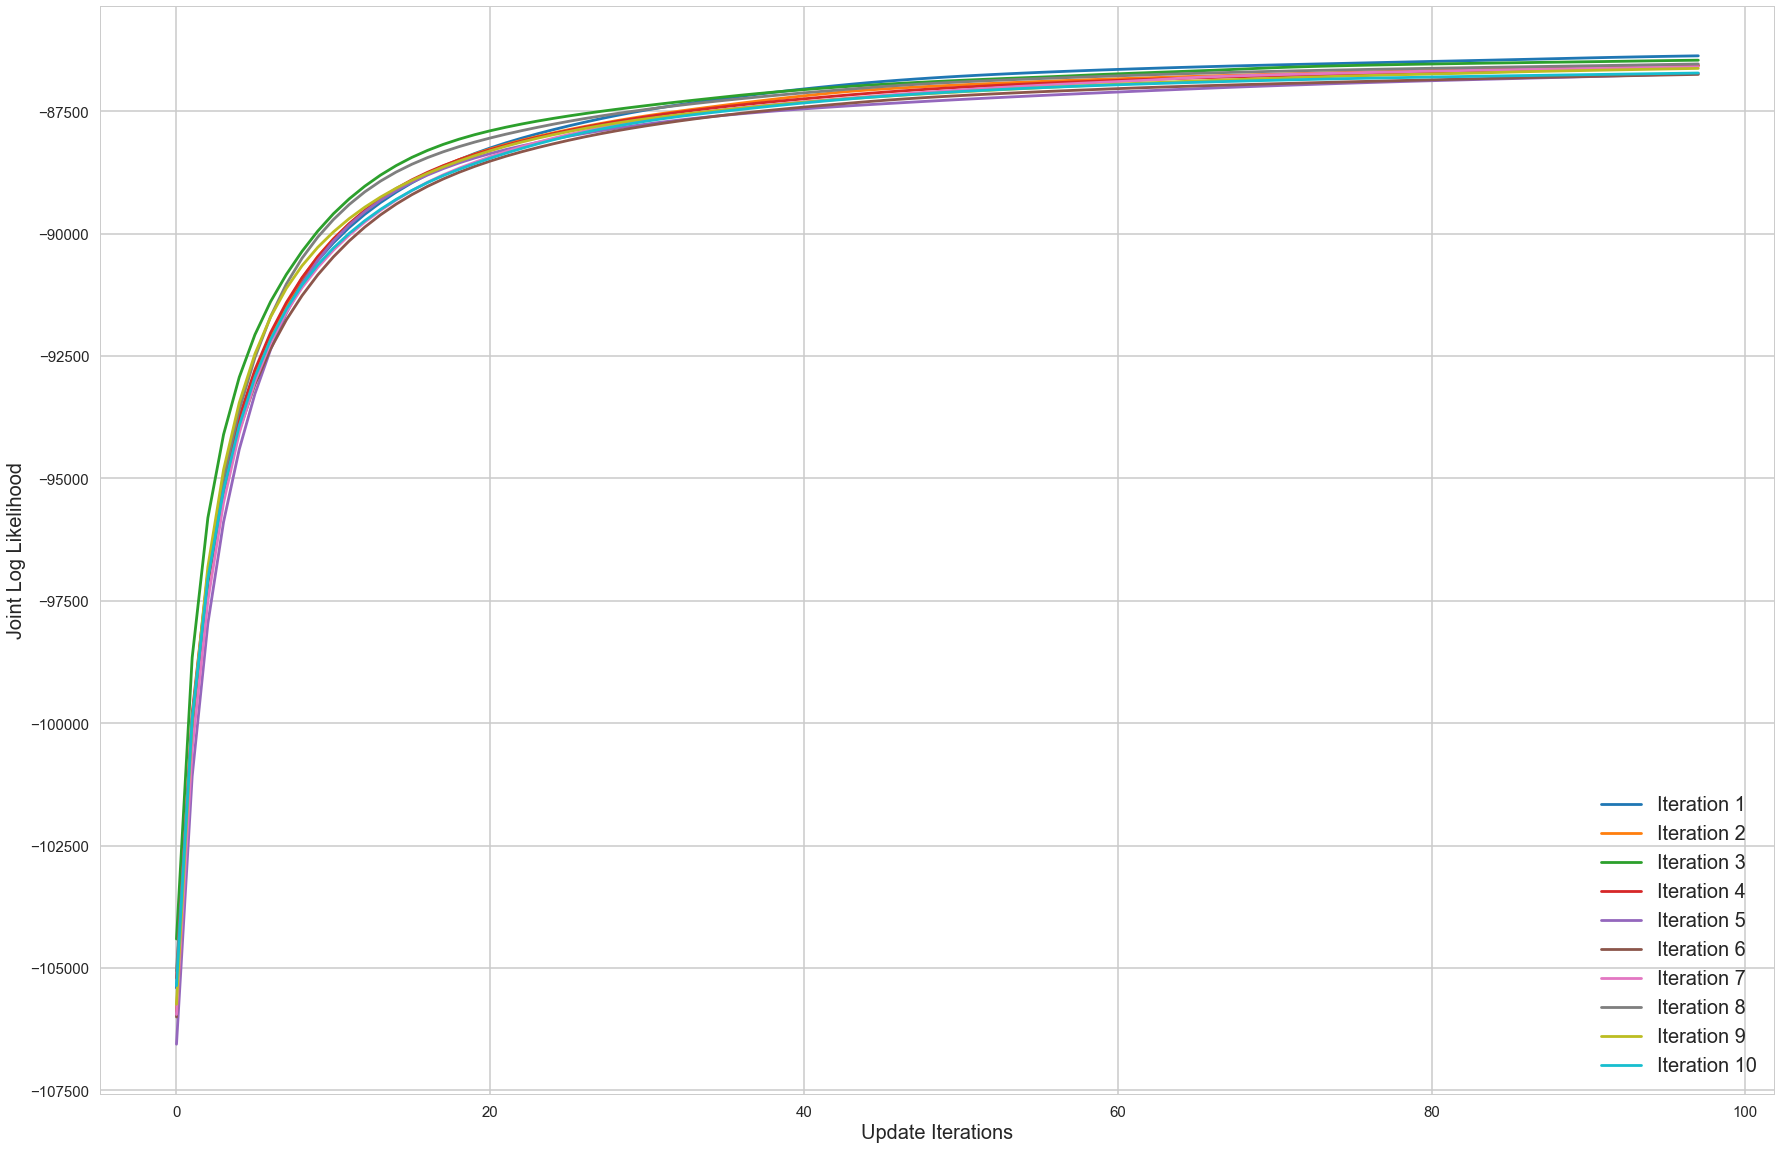

In [49]:
if __name__ == "__main__":
    testPart1()
    testPart2()